# Milestone Project - SkimLit
This is a project for the SkimLit application, which is designed to help users quickly skim through articles and extract key information. This will make reading medical abstracts easier.

Now, we start by classifying the articles into different categories based on their content. The project uses TensorFlow for building and training the model. 

For example, we're going to classify articles into categories such as "Background", "Methods", "Results", and "Conclusion", etc. The model will be trained on a dataset of articles, and it will learn to predict the category of a new article based on its content.

## Import libraries and modules


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import os # For checking filenames

## Download dataset and load it into tensors
In this model, we will use PubMed articles dataset, which contains a collection of biomedical literature.
Then we will find the most wrong prediction.

### Input - output:
**Input**: a paragraph relate on a topic or a subtitle that encoded into numerical tensor (tokenization and embedding)

**Output**: predicted output (a tensor of probabilities of predictions) base on our model working. This answer the question: `"What section should these sentences belong to?"`

In [3]:
#!cd datasets & git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git 
! cd datasets & ls pubmed-rct

In [4]:
! ls datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
! ls datasets/pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [5]:
# Using "20k datasets" with numbers replaced by "@" sign
data_dir = "datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocessing data
It's time to become one with it.
The best way is visualizating them!

In [6]:
# Function for read all content in lines of a document
def get_lines(filename):
    """
    read filename and returns the lines of text as a list.

    Args:
        filename (str): containing the target filepath
    """
    with open(filename, "r") as f:
        return f.readlines()

In [7]:
# Read in training line
train_lines = get_lines(data_dir + "train.txt")
train_lines

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
test_lines = get_lines(data_dir + "test.txt")
test_lines[:10]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

The form of data would be presented on is:
> [{
>    
>    'line_number': 0,
>
>    'target': 'BACKGROUND'
>
>   'text' : 'e.g. \n'
>
>    'total_line': 11
>
> }, ...]

In [9]:
# Fucntion turns each of out datasets into above format
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename) # get all line of filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts
    
    for line in input_lines:
        if line.startswith("###"): # Check if this is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract_lines
        elif line.isspace():
            abstract_lines_split = abstract_lines.splitlines()
    
             # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                if len(target_text_split) < 2:
                    continue
                line_data = {
                    "line_number": abstract_line_number,
                    "target": target_text_split[0],
                    "text": target_text_split[1].lower(),
                    "total_lines": len(abstract_lines_split) - 1
                }

                abstract_samples.append(line_data)
        else: # the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples

In [10]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name of validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [11]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
len(train_lines)

210040

We need to turn into DataFrame if wanna further visualize them

In [13]:
# Turn into dataframe
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

print(train_df.head(14))
print(train_df.target.value_counts())

    line_number       target  \
0             0    OBJECTIVE   
1             1      METHODS   
2             2      METHODS   
3             3      METHODS   
4             4      METHODS   
5             5      METHODS   
6             6      RESULTS   
7             7      RESULTS   
8             8      RESULTS   
9             9      RESULTS   
10           10      RESULTS   
11           11  CONCLUSIONS   
12            0   BACKGROUND   
13            1   BACKGROUND   

                                                 text  total_lines  
0   to investigate the efficacy of @ weeks of dail...           11  
1   a total of @ patients with primary knee oa wer...           11  
2   outcome measures included pain reduction and i...           11  
3   pain was assessed using the visual analog pain...           11  
4   secondary outcome measures included the wester...           11  
5   serum levels of interleukin @ ( il-@ ) , il-@ ...           11  
6   there was a clinically relevant 

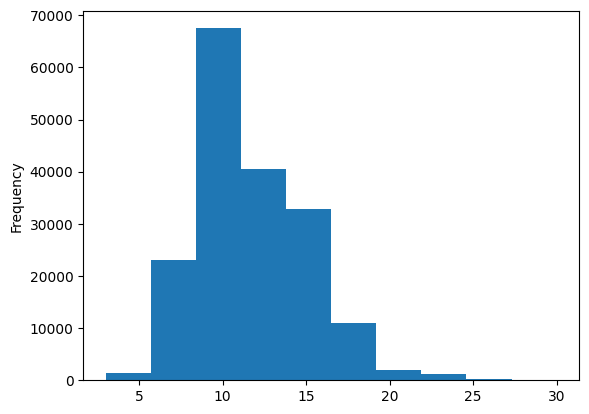

In [14]:
# Check the length of the different lines
train_df.total_lines.plot.hist();

In [15]:
# Get lists of sentences
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

### Turn our labels in to numerical tensor embedded
*Machine Learning requires numerical values as inputs and outputs.*

**One hot encoder**

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output= False) # we want non_sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

In [17]:
tf.constant(train_labels_one_hot)

2025-09-14 11:12:28.081148: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

**Label encode labels**

In [18]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

## Get class names and numer of classes from LabelEncoder instance

In [19]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [20]:
# Download the helper function
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [21]:
from helper_functions import calculate_results

## Trainning with various types of models

### Model 0: Naive Bayes with TF-IDF

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

Nice! Looks like *72.2%* accuracy will be the number to beat with our deeper models.

Now let's make some predictions with our baseline model to further evaluate it.

In [24]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [25]:
baseline_results = calculate_results(y_true=val_labels_encoded, y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

*That is the end of model 0 with Tf Idf, for deeper upgrade, we have to prepare our data further.*

### Preparing data for deep learning model
We can use the `TextVectorization` layer from TensorFlow to turn our text into embedded numerical tensors.

Average length: 26.338269273494777


(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

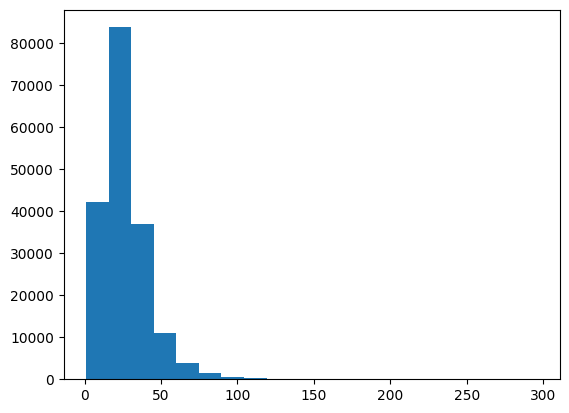

In [26]:
from tensorflow.keras import layers
import numpy as np
# How long is each sentence on average
sentence_len = [len(sentence.split()) for sentence in train_sentences]
sentence_len

print(f"Average length: {np.mean(sentence_len)}")
plt.hist(sentence_len, bins=20)

In [27]:
output_seq_len = int(np.percentile(sentence_len, 95))
print(output_seq_len)
print(np.max(sentence_len))

55
296


Wonderful! It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

### Creating a text vectorization layer

In [28]:
# Define max_tokens
max_tokens = 68000

# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_seq_len)

Adapt text vectorizer to training sentences

In [29]:
text_vectorizer.adapt(train_sentences)

`TextVectorization` lưu một bảng tra cứu token → index ở bên trong (dùng TensorFlow lookup table).

Nếu bạn chưa gọi `.adapt()` thì bảng đó rỗng, nên khi gọi `.call()` (tức là khi bạn làm text_vectorizer([...])) nó sẽ báo "table not initialized".

👉 Sau khi `.adapt(train_sentences)`, nó mới biết từ nào trong vocabulary để map thành số.

Test our text vectorizer on random training sentences

In [30]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\n Vectorized text: {text_vectorizer([target_sentence])}") 

Text:
we will also investigate whether the intervention was delivered as designed ( fidelity ) by coding audiotaped workshops and interventionist delivery reports , and operated as hypothesised ( process evaluation ) by analysing responses to theory-based postal questionnaires .

Length of text: 273

 Vectorized text: [[   43    95   138   331   180     2    38    10   785    25   560  3729
     22  7912 17503  7278     3 37789   479  1418     3  3686    25  5743
    829   381    22 14255   442     6  5101  7808   913     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [31]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [32]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom-text embedding
*Turns positive integers (indexes) into dense vectors of fixed size.*

In [33]:
# Create the token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: Different embedding sizes result in drastically different number of params,
                               mask_zero=True, # Use masking to handle sequence length
                               name="token_embedding")

In [34]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
we will also investigate whether the intervention was delivered as designed ( fidelity ) by coding audiotaped workshops and interventionist delivery reports , and operated as hypothesised ( process evaluation ) by analysing responses to theory-based postal questionnaires .

Sentence after vectorization (before embedding):
[[   43    95   138   331   180     2    38    10   785    25   560  3729
     22  7912 17503  7278     3 37789   479  1418     3  3686    25  5743
    829   381    22 14255   442     6  5101  7808   913     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.0013345  -0.04270649 -0.01692028 ... -0.00062089  0.0167938
    0.00417747]
  [-0.04749436  0.04600391 -0.0341677  ...  0.03652469  0.0149518
    0.01731976]
  [ 0.02011938 -0.01112419 -0.03491117 ... -0.0186317  -0.03716953
    0.04249991]
  ...
  [-0.02057332 -0.03760

## Create datasets (as fast as possible)
We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the `tf.data API` provides methods which enable faster data loading.

`tf.data`: Build TensorFlow input pipelines
Better performance with the tf.data API
The main steps we'll want to use with our data is to turn it into a PrefetchDataset of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset we can use the methods `batch()` and `prefetch()`, the parameter `tf.data.AUTOTUNE` will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [35]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

### Prefectching
Prefeching overlaps the preprocessing and model execution of a training step. While the model is executing training step *n*, the input pipeline is reading the data for step *n+1*. This can **reduce the time** it takes to train a model.

The `tf.data.Dataset.prefetch()` method creates a dataset that prefetches elements from this dataset. The argument `buffer_size` is the number of elements to prefetch. Setting `buffer_size=tf.data.AUTOTUNE` allows the tf.data runtime to tune the value dynamically at runtime.

> We have to turn batch(32) before prefetch(tf.data.AUTOTUNE) because prefetching works on the data that has already been batched.

In [36]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Convolutional Neural Network (CNN) 1D with token embeddings

> Input(text) -> Tokenization -> Embedding -> Conv1D -> GlobalMaxPool1D -> Dense -> Output (label probabilities)

The main component we'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

In [37]:
# Create model with sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs) # vectorize text inputs

token_embeddings = token_embed(text_vectors) # Create embedding

x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector

outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

/home/dikhangcshcmut/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [38]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",# if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get summary of Conv1D model
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # Only 10% of the dataset

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 54s 95ms/step - accuracy: 0.5101 - loss: 1.1866 - val_accuracy: 0.7337 - val_loss: 0.7012
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 51s 92ms/step - accuracy: 0.7421 - loss: 0.6933 - val_accuracy: 0.7696 - val_loss: 0.6423
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.7687 - loss: 0.6268 - val_accuracy: 0.7839 - val_loss: 0.5999


In [40]:
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7856 - loss: 0.5980


[0.6003734469413757, 0.7854825854301453]

In [41]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[4.1919145e-01, 1.8552664e-01, 9.1434017e-02, 2.6909867e-01,
        3.4749255e-02],
       [3.9479640e-01, 3.3805794e-01, 8.9625716e-03, 2.4826244e-01,
        9.9206278e-03],
       [1.5108991e-01, 9.4056018e-03, 2.7630576e-03, 8.3664411e-01,
        9.7349126e-05],
       ...,
       [4.2704992e-06, 8.2542590e-04, 7.2483078e-04, 2.2516745e-06,
        9.9844319e-01],
       [4.9794480e-02, 4.4086343e-01, 9.2095762e-02, 6.2559254e-02,
        3.5468706e-01],
       [2.1408747e-01, 6.1481869e-01, 6.0444865e-02, 5.3097669e-02,
        5.7551429e-02]], dtype=float32)

In [42]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [43]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.54825896994572,
 'precision': 0.7818937862002728,
 'recall': 0.7854825896994572,
 'f1': 0.7829149940433677}

In [44]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [45]:
from tabulate import tabulate  # pip install tabulate

def compare_results(baseline_results: dict, new_results: dict, digits: int = 4):
    rows = []
    all_keys = set(baseline_results.keys()) | set(new_results.keys())

    for key in all_keys:
        base_val = baseline_results.get(key, None)
        new_val = new_results.get(key, None)
        diff, status = None, ""
        
        if base_val is not None and new_val is not None:
            diff = new_val - base_val
            if diff > 0:
                status = "Higher"
            elif diff < 0:
                status = "Lower"
            else:
                status = "Equal"

        rows.append([
            key,
            None if base_val is None else round(base_val, digits),
            None if new_val is None else round(new_val, digits),
            None if diff is None else round(diff, digits),
            status
        ])

    print(tabulate(rows, headers=["Metric", "Baseline", "New", "Diff", "Status"], tablefmt="pretty"))
    return rows


In [46]:
compare_results(baseline_results=baseline_results, new_results=model_1_results)

+-----------+----------+---------+--------+--------+
|  Metric   | Baseline |   New   |  Diff  | Status |
+-----------+----------+---------+--------+--------+
|  recall   |  0.7218  | 0.7855  | 0.0637 | Higher |
| accuracy  | 72.1832  | 78.5483 | 6.365  | Higher |
|    f1     |  0.6989  | 0.7829  | 0.084  | Higher |
| precision |  0.7186  | 0.7819  | 0.0632 | Higher |
+-----------+----------+---------+--------+--------+


[['recall', 0.7218, 0.7855, 0.0637, 'Higher'],
 ['accuracy', 72.1832, 78.5483, 6.365, 'Higher'],
 ['f1', 0.6989, 0.7829, 0.084, 'Higher'],
 ['precision', 0.7186, 0.7819, 0.0632, 'Higher']]

### Prepare datasets for training model 2

Now we use pretrained word embeddings from TensorFlow Hub.
The paper originally use GloVe embeddings, but we can use any pretrained embeddings we want. As we going to stick with the later created USE (Universal Sentence Encoder) pretrained embeddings.

In [47]:
# Download pretrained TensorFlow Hub USE
import tf_keras
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

/home/dikhangcshcmut/.local/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [48]:
# Test our pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embeding:\n{use_embedded_sentence}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 without active warming from the beginning of the surgical procedure until the end of the bonding period , the mean ( sd ) neonatal core temperature decreased to @ ( @ ) c. seventeen of @ ( @ % ) newborns became hypothermic ( defined as a core temperature below @ c ) .
Sentence after embeding:
[[-0.00537052  0.03100502 -0.00696816 -0.06377052 -0.06976446 -0.05909478
   0.03567753 -0.0164481  -0.01233806  0.06230726  0.03580756 -0.07186917
  -0.00927098 -0.04589454  0.04591209 -0.05245995 -0.08091874  0.01803452
  -0.0111625  -0.03750562 -0.05214513 -0.03867839  0.01826514  0.07458016
   0.04586868 -0.00295039  0.07298036  0.01437708 -0.04327703 -0.00019666
  -0.00951387  0.06864578 -0.06117538  0.01308231 -0.05023016 -0.02086549
  -0.04712321  0.01359246  0.0228106  -0.05632652  0.07360028  0.00689551
  -0.00679676  0.01011962  0.05400375 -0.01134736  0.04179182 -0.02247148
   0.02367038 -0.04017887 -0.00769982 -0.00796166 -0.06126587 -0.03072805
   0.05905199 -0.05506

2025-09-14 11:21:39.769701: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


### Building and fitting an NLP feature extractor model using  pretrained embeddings from TensorFlow Hub

In [49]:
import tf_keras as keras
def create_functional_model():
    """Sử dụng Functional API - cách chắc chắn nhất"""
    
    print("Creating model using Functional API...")
    
    # Input
    text_input = keras.layers.Input(shape=(), dtype=tf.string, name='text_input')
    
    # TensorFlow Hub layer
    encoder = hub.KerasLayer(
        "https://tfhub.dev/google/universal-sentence-encoder/4",
        trainable=False,
        name="universal_sentence_encoder"
    )
    
    # Apply encoder
    embeddings = encoder(text_input)
    
    # Dense layers (smaller size for memory efficiency)
    x = keras.layers.Dense(64, activation='relu', name='dense1')(embeddings)
    x = layers.Dense(32, activation='relu', name='dense2')(x)
    # Output layer
    outputs = keras.layers.Dense(5, activation='softmax', name='predictions')(x)
    
    # Create model
    model = keras.Model(inputs=text_input, outputs=outputs, name='text_classifier')
    
    return model

In [50]:
model_2 = create_functional_model()

Creating model using Functional API...


In [51]:
print("="*60)
print("VERSION CHECK")
print("="*60)
print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__ if hasattr(hub, '__version__') else "Unknown")
print("Keras version:", tf.keras.__version__)

VERSION CHECK
TensorFlow version: 2.19.0
TensorFlow Hub version: 0.16.1
Keras version: 3.10.0


In [52]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "text_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense1 (Dense)              (None, 64)                32832     
                                                                 
 tf.cast (TFOpLambda)        (None, 64)                0         
                                                                 
 tf.linalg.matmul (TFOpLamb  (None, 32)                0         
 da)                                                             
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 32)            

In [53]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 0.9913 - accuracy: 0.6184 - val_loss: 0.8172 - val_accuracy: 0.6872
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.7815 - accuracy: 0.6964 - val_loss: 0.7628 - val_accuracy: 0.7008
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.7595 - accuracy: 0.7093 - val_loss: 0.7498 - val_accuracy: 0.7088


In [54]:
# Evaluate on the validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.7478 - accuracy: 0.7108


[0.7478078007698059, 0.7108103036880493]

In [55]:
# Calculate the probabilities of prediction
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 6s 6ms/step


array([[4.9612868e-01, 3.4238574e-01, 4.2697033e-03, 1.4418447e-01,
        1.3031425e-02],
       [3.1974539e-01, 5.5490327e-01, 8.6075841e-03, 1.0881313e-01,
        7.9306308e-03],
       [1.5769853e-01, 1.8503995e-01, 1.5362721e-02, 6.0954779e-01,
        3.2350954e-02],
       ...,
       [9.3825790e-04, 3.9128130e-03, 4.2596348e-02, 6.5437204e-04,
        9.5189834e-01],
       [3.6137076e-03, 4.1950915e-02, 2.1523821e-01, 1.4120806e-03,
        7.3778504e-01],
       [2.7099076e-01, 2.7653286e-01, 3.4660399e-01, 1.9982021e-02,
        8.5890353e-02]], dtype=float32)

In [56]:
# Get the prediction finally
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [57]:
# Get the result finally
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
print(model_2_results)

compare_results(baseline_results=model_1_results, new_results=model_2_results)

{'accuracy': 71.08102740632862, 'precision': 0.7093086201415184, 'recall': 0.7108102740632861, 'f1': 0.7081872499138714}
+-----------+----------+--------+---------+--------+
|  Metric   | Baseline |  New   |  Diff   | Status |
+-----------+----------+--------+---------+--------+
|  recall   |  0.7855  | 0.7108 | -0.0747 | Lower  |
| accuracy  | 78.5483  | 71.081 | -7.4672 | Lower  |
|    f1     |  0.7829  | 0.7082 | -0.0747 | Lower  |
| precision |  0.7819  | 0.7093 | -0.0726 | Lower  |
+-----------+----------+--------+---------+--------+


[['recall', 0.7855, 0.7108, -0.0747, 'Lower'],
 ['accuracy', 78.5483, 71.081, -7.4672, 'Lower'],
 ['f1', 0.7829, 0.7082, -0.0747, 'Lower'],
 ['precision', 0.7819, 0.7093, -0.0726, 'Lower']]

## Model 3: Conv1D with character-level tokenizer and embeddings

### Create a character-level tokenizer

In [58]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [59]:
def split_chars(text):
    return " ".join(list(text))

In [60]:
split_chars(random_train_sentence)

'w i t h o u t   a c t i v e   w a r m i n g   f r o m   t h e   b e g i n n i n g   o f   t h e   s u r g i c a l   p r o c e d u r e   u n t i l   t h e   e n d   o f   t h e   b o n d i n g   p e r i o d   ,   t h e   m e a n   (   s d   )   n e o n a t a l   c o r e   t e m p e r a t u r e   d e c r e a s e d   t o   @   (   @   )   c .   s e v e n t e e n   o f   @   (   @   %   )   n e w b o r n s   b e c a m e   h y p o t h e r m i c   (   d e f i n e d   a s   a   c o r e   t e m p e r a t u r e   b e l o w   @   c   )   .'

In [61]:
# Split a sequence data splits into character-level
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

149.3662574983337


(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

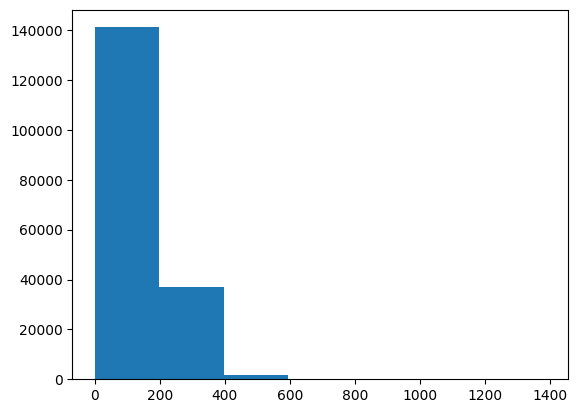

In [62]:
# The avg character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
print(mean_char_len)
# Check the distribution of sequence
plt.hist(char_lens, bins=7)

In [63]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [64]:
#! Get all keyboard character
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [65]:
# Create char_level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [66]:
# Adapt
char_vectorizer.adapt(train_chars)
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters:{char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters:['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [67]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
c y a   +   p r e d n i s o l o n e   t r e a t m e n t   i s   e f f e c t i v e   f o r   i m n   w i t h   a s s o c i a t e d   s r n s   a t   a   c @   o f   @   n g / m l   .

Length of chars: 74

Vectorized chars:
[[11 19  5 14  8  2 10  6  4  9  7 12  7  6  2  3  8  2  5  3 15  2  6  3
   4  9  2 17 17  2 11  3  4 21  2 17  7  8  4 15  6 20  4  3 13  5  9  9
   7 11  4  5  3  2 10  9  8  6  9  5  3  5 11  7 17  6 18 15 12  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0

You'll notice sequences with a length shorter than 290 (output_seq_char_length) get padded with zeros on the end, this ensures all sequences passed to our model are the same length.

Also, due to the standardize parameter of TextVectorization being "lower_and_strip_punctuation" and the split parameter being "whitespace" by default, symbols (such as @) and spaces are removed.



### Create a character-level embedding layer

In [68]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
c y a   +   p r e d n i s o l o n e   t r e a t m e n t   i s   e f f e c t i v e   f o r   i m n   w i t h   a s s o c i a t e d   s r n s   a t   a   c @   o f   @   n g / m l   .

Embedded chars (after vectorization and embedding):
[[[-0.04508284 -0.02621712  0.01643139 ... -0.01419684 -0.03640094
   -0.02029769]
  [ 0.04309929  0.02933237  0.03566332 ...  0.03152485  0.00294503
   -0.00440897]
  [-0.01540841 -0.04783112  0.04856812 ...  0.00229766 -0.04700874
    0.01531248]
  ...
  [ 0.00241507 -0.01543428  0.0457677  ... -0.03593517  0.01869326
    0.04710608]
  [ 0.00241507 -0.01543428  0.0457677  ... -0.03593517  0.01869326
    0.04710608]
  [ 0.00241507 -0.01543428  0.0457677  ... -0.03593517  0.01869326
    0.04710608]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [69]:
def build_model(char_vectorizer, char_embed, num_classes: int):
    """
    Build a Conv1D text classification model on character embeddings.
    
    Args:
        char_vectorizer: TextVectorization layer (char-level).
        char_embed: Embedding layer for characters.
        num_classes: số lớp output (phân loại).
    
    Returns:
        tf.keras.Model
    """
    # Input:
    inputs = tf.keras.layers.Input(shape=(1,), dtype = tf.string)
    
    # Vectorize -> Embedding
    char_vectors = char_vectorizer(inputs)
    char_embeddings = char_embed(char_vectors)
    
    # Conv1D + GlobalMaxPool
    x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
    x = tf.keras.layers.GlobalMaxPool1D()(x)
    
    # Dense output
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs,
                            outputs=outputs,
                            name="model_3_conv1D_char_embedding")
    
    return model

In [70]:
model_3 = build_model(char_vectorizer, char_embed, num_classes=5)
model_3.summary()

Model: "model_3_conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [72]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [73]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4214 - loss: 1.3954 - val_accuracy: 0.5858 - val_loss: 1.0444
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5752 - loss: 1.0481 - val_accuracy: 0.6326 - val_loss: 0.9394
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6293 - loss: 0.9462 - val_accuracy: 0.6702 - val_loss: 0.8645


### Evaluate model 3

In [74]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6558 - loss: 0.8892


[0.8954443335533142, 0.6531510949134827]

In [75]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


{'accuracy': 65.31510658016683,
 'precision': 0.6521958486511811,
 'recall': 0.6531510658016683,
 'f1': 0.6407582478024286}

In [76]:
compare_results(model_1_results, model_3_results)

+-----------+----------+---------+----------+--------+
|  Metric   | Baseline |   New   |   Diff   | Status |
+-----------+----------+---------+----------+--------+
|  recall   |  0.7855  | 0.6532  | -0.1323  | Lower  |
| accuracy  | 78.5483  | 65.3151 | -13.2332 | Lower  |
|    f1     |  0.7829  | 0.6408  | -0.1422  | Lower  |
| precision |  0.7819  | 0.6522  | -0.1297  | Lower  |
+-----------+----------+---------+----------+--------+


[['recall', 0.7855, 0.6532, -0.1323, 'Lower'],
 ['accuracy', 78.5483, 65.3151, -13.2332, 'Lower'],
 ['f1', 0.7829, 0.6408, -0.1422, 'Lower'],
 ['precision', 0.7819, 0.6522, -0.1297, 'Lower']]

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

* *1.* Create a token-level model (similar to model_1)
* *2.* Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
* *3.* Combine (using layers.Concatenate) the outputs of 1 and 2
* *4.* Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
* *5.* Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [77]:
# 1. Setup token inputs/model
import tf_keras as keras
token_inputs = keras.layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = keras.layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectorizer = tf_keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")
char_vectorizer.adapt(train_chars)
char_vectors = char_vectorizer(char_inputs)
char_embed = keras.layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")
char_embeddings = char_embed(char_vectors)
char_bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = keras.layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = keras.layers.Dropout(0.5)(combined_dense)
output_layer = keras.layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [78]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

In [79]:
#Compile model 4
model_4.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

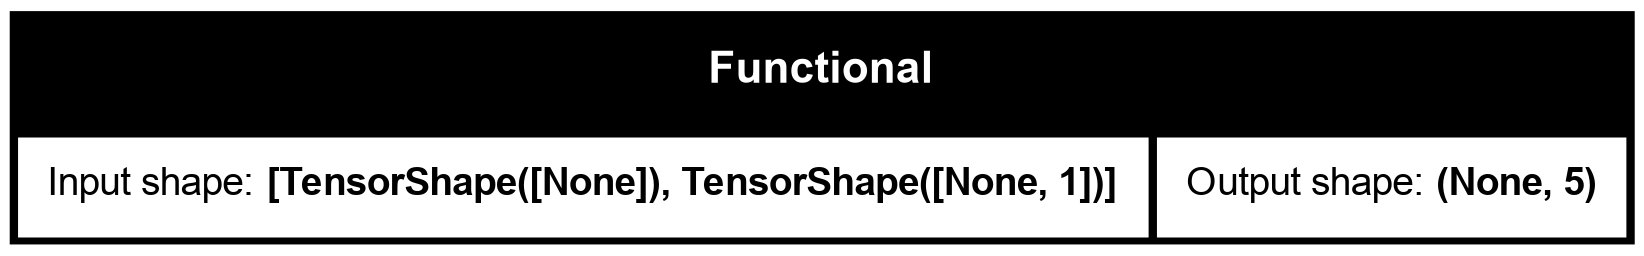

In [80]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

### Combining token and character data into a tf.data dataset

In [81]:
# Train data
train_char_token_data = tf.data.Dataset.from_tensor_slices({
    "token_input": train_sentences,
    "char_input": train_chars
})
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices({
    "token_input": val_sentences,
    "char_input": val_chars
})
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [82]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=({'token_input': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'char_input': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=({'token_input': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'char_input': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [83]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 53s 88ms/step - loss: 0.9715 - accuracy: 0.6128 - val_loss: 0.7876 - val_accuracy: 0.6985
Epoch 2/3
562/562 [==============================] - 48s 86ms/step - loss: 0.7962 - accuracy: 0.6921 - val_loss: 0.7166 - val_accuracy: 0.7244
Epoch 3/3
562/562 [==============================] - 47s 84ms/step - loss: 0.7742 - accuracy: 0.7053 - val_loss: 0.6949 - val_accuracy: 0.7414


### Evaluate model 4

In [84]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.7045 - accuracy: 0.7332


[0.7045021653175354, 0.7332186102867126]

In [85]:
# Calculate pred_probs
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 23s 24ms/step


array([[4.4628787e-01, 3.6446235e-01, 3.7947851e-03, 1.7979208e-01,
        5.6629418e-03],
       [3.6907580e-01, 3.9995354e-01, 2.7347687e-03, 2.2717553e-01,
        1.0602814e-03],
       [3.2499528e-01, 1.2564157e-01, 3.6620837e-02, 4.9051243e-01,
        2.2229830e-02],
       ...,
       [9.6147694e-04, 7.8279311e-03, 8.4872432e-02, 5.3091953e-04,
        9.0580720e-01],
       [9.8281018e-03, 8.1676312e-02, 2.0014191e-01, 5.0700759e-03,
        7.0328367e-01],
       [2.5459057e-01, 4.1512382e-01, 2.6383632e-01, 2.5483796e-02,
        4.0965542e-02]], dtype=float32)

In [86]:
# Convert to preds
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [87]:
# Print result finally
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 73.32185886402753,
 'precision': 0.7336741621041427,
 'recall': 0.7332185886402753,
 'f1': 0.7318151741595001}

In [88]:
compare_results(model_3_results, model_4_results)

+-----------+----------+---------+--------+--------+
|  Metric   | Baseline |   New   |  Diff  | Status |
+-----------+----------+---------+--------+--------+
|  recall   |  0.6532  | 0.7332  | 0.0801 | Higher |
| accuracy  | 65.3151  | 73.3219 | 8.0068 | Higher |
|    f1     |  0.6408  | 0.7318  | 0.0911 | Higher |
| precision |  0.6522  | 0.7337  | 0.0815 | Higher |
+-----------+----------+---------+--------+--------+


[['recall', 0.6532, 0.7332, 0.0801, 'Higher'],
 ['accuracy', 65.3151, 73.3219, 8.0068, 'Higher'],
 ['f1', 0.6408, 0.7318, 0.0911, 'Higher'],
 ['precision', 0.6522, 0.7337, 0.0815, 'Higher']]

### Model 5: Transfer learning with pretrained BERT and other transformer models

In [89]:
train_df.head(10)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


### Create positional embeddings

In [90]:
# find different line numbers
train_df["line_number"].value_counts

<bound method IndexOpsMixin.value_counts of 0          0
1          1
2          2
3          3
4          4
          ..
180035     7
180036     8
180037     9
180038    10
180039    11
Name: line_number, Length: 180040, dtype: int64>

<Axes: ylabel='Frequency'>

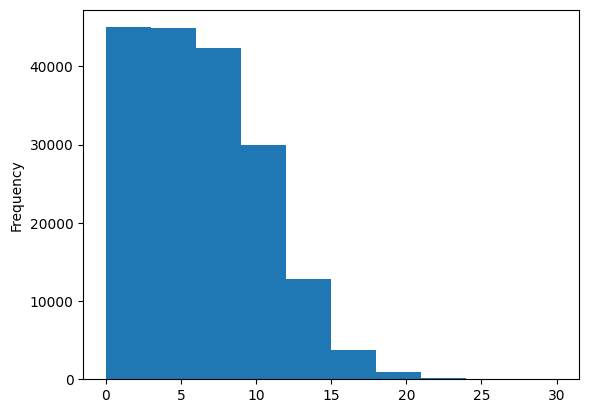

In [91]:
train_df.line_number.plot.hist()

In [92]:
# create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64


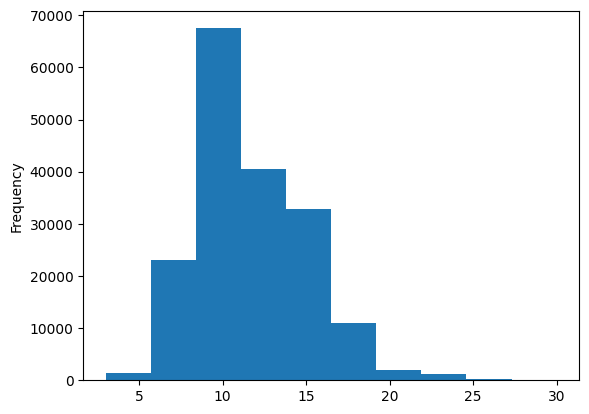

In [93]:
print(train_df["total_lines"].value_counts())
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [94]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [95]:
# Create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

### Building a tribrid embedding model
More specifically we're going to go through the following steps:

* *1.* Create a token-level model (similar to model_1)
* *2.* Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
* *3.* Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
* *4.* Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
* *5.* Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
* *6.* Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
* *7.* Create an output layer to accept the tribrid embedding and output predicted label probabilities
* *8.* Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [96]:
# 1. Token inputs
token_inputs = keras.layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = keras.Model(inputs=token_inputs,
                        outputs=token_outputs)

# 2. Char inputs
char_inputs = keras.layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(32))(char_embeddings)
char_model = keras.Model(inputs=char_inputs,
                        outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = keras.layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = keras.Model(inputs=line_number_inputs,
                                outputs=x)

# 4. Total lines inputs
total_lines_inputs = keras.layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = keras.Model(inputs=total_lines_inputs,
                                outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = keras.layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = keras.layers.Dense(256, activation="relu")(combined_embeddings)
z = keras.layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = keras.layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = keras.layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = keras.Model(inputs=[line_number_model.input,
                                total_line_model.input,
                                token_model.input, 
                                char_model.input],
                         outputs=output_layer)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 line_number_input (InputLa  [(None, 15)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 total_lines_input (InputLa  [(None, 20)]                 0         []                            
 yer)                                                                                             
                                                                                            

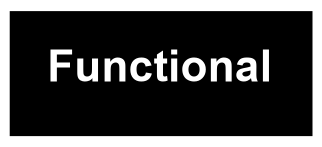

In [97]:
model_5.summary()
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [98]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<tf_keras.src.engine.input_layer.InputLayer object at 0x7113370824d0> True
<tf_keras.src.engine.input_layer.InputLayer object at 0x71133737b640> True
<tf_keras.src.engine.input_layer.InputLayer object at 0x71139607fb80> True
<tf_keras.src.engine.input_layer.InputLayer object at 0x711337bcdae0> True
<tf_keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x711337082a40> True
<tf_keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x711337bd01f0> True
<tf_keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x7113378dd8d0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x711395a33d30> False
<tf_keras.src.layers.core.embedding.Embedding object at 0x711337081090> True
<tf_keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x711337bcd810> True
<tf_keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x711337a90eb0> True
<tf_keras.src.layers.core.dense.Dense object at 0x711334558f10> True
<tf_keras.src.layers.rnn.bidirectional.Bidirectional object 

In [99]:
model_5.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets and fit tribrid model

In [100]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [101]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 54s 91ms/step - loss: 1.1373 - accuracy: 0.6933 - val_loss: 1.0413 - val_accuracy: 0.7699
Epoch 2/3
562/562 [==============================] - 51s 91ms/step - loss: 1.0182 - accuracy: 0.7805 - val_loss: 0.9915 - val_accuracy: 0.7992
Epoch 3/3
562/562 [==============================] - 49s 88ms/step - loss: 0.9890 - accuracy: 0.7968 - val_loss: 0.9694 - val_accuracy: 0.8185


In [102]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 22s 23ms/step


array([[0.4642896 , 0.16795103, 0.02146174, 0.32019326, 0.02610436],
       [0.49118018, 0.21393958, 0.04324912, 0.22797628, 0.02365488],
       [0.32571805, 0.10266831, 0.12493762, 0.3902508 , 0.05642522],
       ...,
       [0.0380742 , 0.09349103, 0.09077375, 0.03597313, 0.74168795],
       [0.05603192, 0.21977216, 0.15311018, 0.0488272 , 0.5222586 ],
       [0.23617983, 0.5040932 , 0.17455319, 0.03527851, 0.04989531]],
      dtype=float32)

In [103]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.548259,0.781894,0.785483,0.782915
pretrained_token_embed,71.081027,0.709309,0.710810,0.708187
custom_char_embed_conv1d,65.315107,0.652196,0.653151,0.640758
hybrid_char_token_embed,73.321859,0.733674,0.733219,0.731815
tribrid_pos_char_token_embed,81.070436,0.808790,0.810704,0.809037


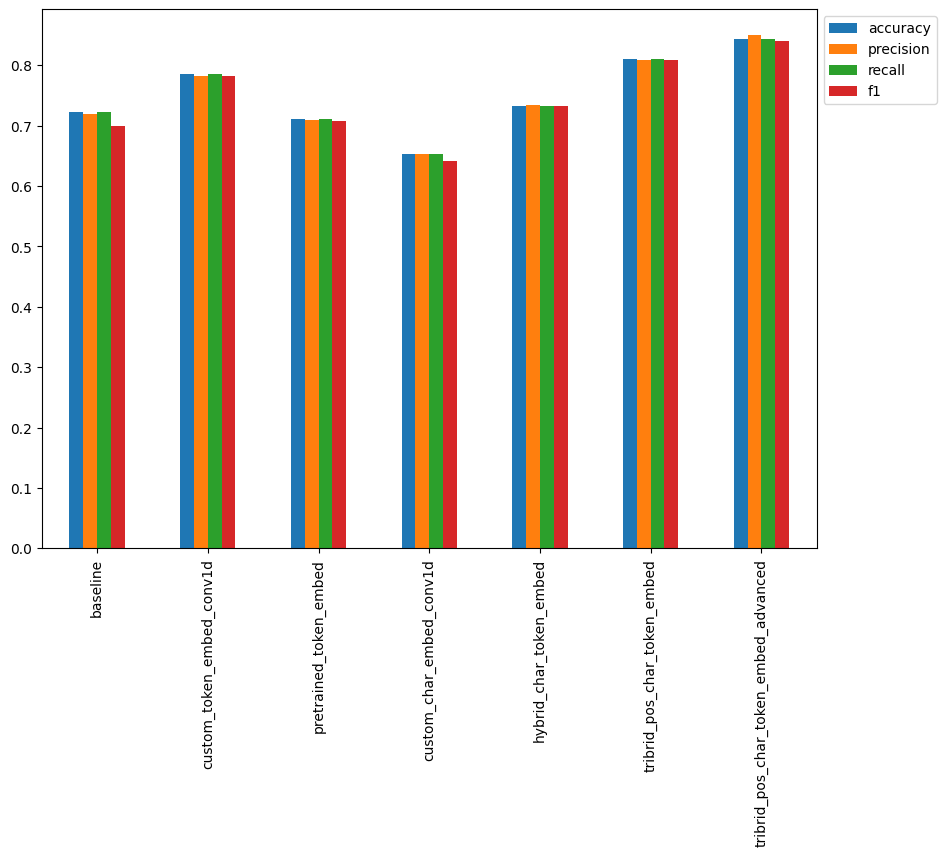

In [136]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

## Save and load best performing model

In [105]:
model_5.save("skimlit_tribrid_model.h5")


/home/dikhangcshcmut/.local/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TypeError: Layer tf.nn.bias_add_1 was passed non-JSON-serializable arguments. Arguments had types: {'bias': <class 'keras.src.backend.Variable'>, 'data_format': <class 'str'>}. They cannot be serialized out when saving the model.

### Evaluate model on test dataset

In [106]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [107]:
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 18s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [109]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 80.45462087273934,
 'precision': 0.8027193939696479,
 'recall': 0.8045462087273934,
 'f1': 0.8028627434896108}

It seems our best model (so far) still has some ways to go to match the performance of the results in the paper (their model gets 90.0 F1-score on the test dataset, where as ours gets ~82.1 F1-score).

However, as we discussed before our model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset. We also haven't fine-tuned our pretrained embeddings (the paper fine-tunes GloVe embeddings). So there's a couple of extensions we could try to improve our results.

## Find most wrong predictions

In [110]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 4.18 s, sys: 0 ns, total: 4.18 s
Wall time: 4.2 s


['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'OBJECTIVE',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'METHODS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULT

In [111]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,line_number,target,text,total_lines,prediction,pred_prob,correct
0,0,BACKGROUND,this study analyzed liver function abnormaliti...,8,OBJECTIVE,0.435406,False
1,1,RESULTS,a post hoc analysis was conducted with the use...,8,BACKGROUND,0.329354,False
2,2,RESULTS,liver function tests ( lfts ) were measured at...,8,METHODS,0.846995,False
3,3,RESULTS,survival analyses were used to assess the asso...,8,METHODS,0.665926,False
4,4,RESULTS,the percentage of patients with abnormal lfts ...,8,RESULTS,0.657970,True
5,5,RESULTS,when mean hemodynamic profiles were compared i...,8,RESULTS,0.874772,True
6,6,RESULTS,multivariable analyses revealed that patients ...,8,RESULTS,0.460928,True
7,7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,8,CONCLUSIONS,0.300670,True
8,8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,RESULTS,0.474942,False
9,0,BACKGROUND,minimally invasive endovascular aneurysm repai...,12,BACKGROUND,0.430053,True


In [112]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]

# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: 4, Pred: METHODS, Prob: 0.9278427958488464, Line number: symptom outcomes will be assessed and estimates of cost-effectiveness made ., Total lines: 6

Text:
CONCLUSIONS

-----

Target: 0, Pred: OBJECTIVE, Prob: 0.9229703545570374, Line number: to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors ., Total lines: 12

Text:
BACKGROUND

-----

Target: 6, Pred: RESULTS, Prob: 0.916564404964447, Line number: -@ % vs. fish : -@ % vs. fish + s : -@ % ; p < @ ) but there were no significant differences between groups ., Total lines: 9

Text:
METHODS

-----

Target: 4, Pred: METHODS, Prob: 0.9156987071037292, Line number: patients were randomly assigned to receive either moxonidine ( @-@ @ mg daily ) or placebo , along with standard antihypertensive treatment ., Total lines: 12

Text:
RESULTS

-----

Target: 4, Pred: METHODS, Prob: 0.9149799942970276, Line number: the primary endpoint is the cumulative three-year hiv incidence ., Total line

In [113]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2025-09-14 11:30:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6,6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.1’

skimlit_example_abs 100%[===================>]   6,58K  --.-KB/s    in 0s      

2025-09-14 11:30:50 (117 MB/s) - ‘skimlit_example_abstracts.json.1’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

## Data crawling and preprocessing from online sources

In [115]:
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 1.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.1/795.1 kB 3.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 2.0 MB/s eta 0:00:0000:0100:01
Using cached click-8.2.1-py3-none-any.whl (102 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy━━━

In [116]:
abstracts = pd.DataFrame(example_abstracts)
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Old version of spaCy
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object 
# nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"]) 
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [117]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 

# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [118]:
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 1s 870ms/step


array([[0.2964935 , 0.13140433, 0.03848815, 0.49662012, 0.03699391],
       [0.04580008, 0.02136016, 0.78217626, 0.04807703, 0.10258646],
       [0.11052397, 0.07744391, 0.5419003 , 0.1430493 , 0.12708251],
       [0.08471307, 0.14420581, 0.6168562 , 0.05699553, 0.09722937],
       [0.08116735, 0.12649016, 0.4421541 , 0.06510738, 0.28508106],
       [0.04746957, 0.08862465, 0.5529758 , 0.05516713, 0.25576293],
       [0.05245971, 0.14446796, 0.13980721, 0.04169787, 0.62156725],
       [0.04350528, 0.0647186 , 0.41076368, 0.05927503, 0.42173734]],
      dtype=float32)

In [119]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [120]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [121]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


## Extra model 6: Involve the EarlyStopping and ModelCheckpoint callbacks

In [126]:
# 1. Token branch (tăng complexity)
token_inputs = keras.layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
x1 = keras.layers.Dense(256, activation="relu")(token_embeddings)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.Dropout(0.5)(x1)
token_model = keras.Model(inputs=token_inputs, outputs=x1)

# 2. Char branch (BiLSTM lớn hơn)
char_inputs = keras.layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
x2 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(char_embeddings)
x2 = keras.layers.GlobalMaxPooling1D()(x2)  # lấy feature mạnh nhất
x2 = keras.layers.Dense(128, activation="relu")(x2)
x2 = keras.layers.BatchNormalization()(x2)
x2 = keras.layers.Dropout(0.5)(x2)
char_model = keras.Model(inputs=char_inputs, outputs=x2)

# 3. Positional branch (line numbers)
line_number_inputs = keras.layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x3 = keras.layers.Dense(64, activation="relu")(line_number_inputs)
x3 = keras.layers.BatchNormalization()(x3)
line_number_model = keras.Model(inputs=line_number_inputs, outputs=x3)

# 4. Positional branch (total lines)
total_lines_inputs = keras.layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
x4 = keras.layers.Dense(64, activation="relu")(total_lines_inputs)
x4 = keras.layers.BatchNormalization()(x4)
total_line_model = keras.Model(inputs=total_lines_inputs, outputs=x4)

# Gộp embeddings
combined_embeddings = keras.layers.Concatenate(name="token_char_hybrid_embedding")(
    [token_model.output, char_model.output]
)
z = keras.layers.Dense(256, activation="relu")(combined_embeddings)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Dropout(0.5)(z)

# 6. Gộp với positional
z = keras.layers.Concatenate(name="token_char_positional_embedding")(
    [line_number_model.output, total_line_model.output, z]
)

# 7. Output
output_layer = keras.layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Model
model_6 = keras.Model(
    inputs=[line_number_model.input, total_line_model.input, token_model.input, char_model.input],
    outputs=output_layer,
    name="SkimLit_tribrid_plus_attention"
)

# Compile
optimizer = keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
model_6.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model_6.weights.h5", monitor="val_loss",
    save_best_only=True, save_weights_only=True, verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)
# Fit model
history_model_6 = model_6.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=5,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)),
                              callbacks=[early_stopping, checkpoint, reduce_lr])


Epoch 1/5
562/562 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 0.7079
Epoch 1: val_loss improved from inf to 0.49965, saving model to best_model_6.weights.h5
562/562 [==============================] - 76s 130ms/step - loss: 0.8121 - accuracy: 0.7079 - val_loss: 0.4997 - val_accuracy: 0.8075 - lr: 0.0010
Epoch 2/5
562/562 [==============================] - ETA: 0s - loss: 0.5232 - accuracy: 0.7995
Epoch 2: val_loss improved from 0.49965 to 0.48637, saving model to best_model_6.weights.h5
562/562 [==============================] - 75s 134ms/step - loss: 0.5232 - accuracy: 0.7995 - val_loss: 0.4864 - val_accuracy: 0.8092 - lr: 0.0010
Epoch 3/5
562/562 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.8068
Epoch 3: val_loss did not improve from 0.48637
562/562 [==============================] - 62s 110ms/step - loss: 0.4939 - accuracy: 0.8068 - val_loss: 0.4868 - val_accuracy: 0.8152 - lr: 0.0010
Epoch 4/5
562/562 [============================

In [132]:
# load the best weights (from ModelCheckpoint)
load_model = model_6.load_weights("best_model_6.weights.h5")

model_6.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 29s 31ms/step - loss: 0.4224 - accuracy: 0.8434


[0.4224260747432709, 0.8433734774589539]

In [133]:
# Calculate pred_probs
model_6_pred_probs = model_6.predict(val_pos_char_token_dataset, verbose=1)
# Turn prediction probabilities into prediction classes
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
# Calculate results of token-char-positional hybrid model
model_6_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_6_preds)
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results,
                                  "tribrid_pos_char_token_embed_advanced": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

945/945 [==============================] - 30s 31ms/step


,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.548259,0.781894,0.785483,0.782915
pretrained_token_embed,71.081027,0.709309,0.710810,0.708187
custom_char_embed_conv1d,65.315107,0.652196,0.653151,0.640758
hybrid_char_token_embed,73.321859,0.733674,0.733219,0.731815
tribrid_pos_char_token_embed,81.070436,0.808790,0.810704,0.809037
tribrid_pos_char_token_embed_advanced,84.337349,0.850157,0.843373,0.839583


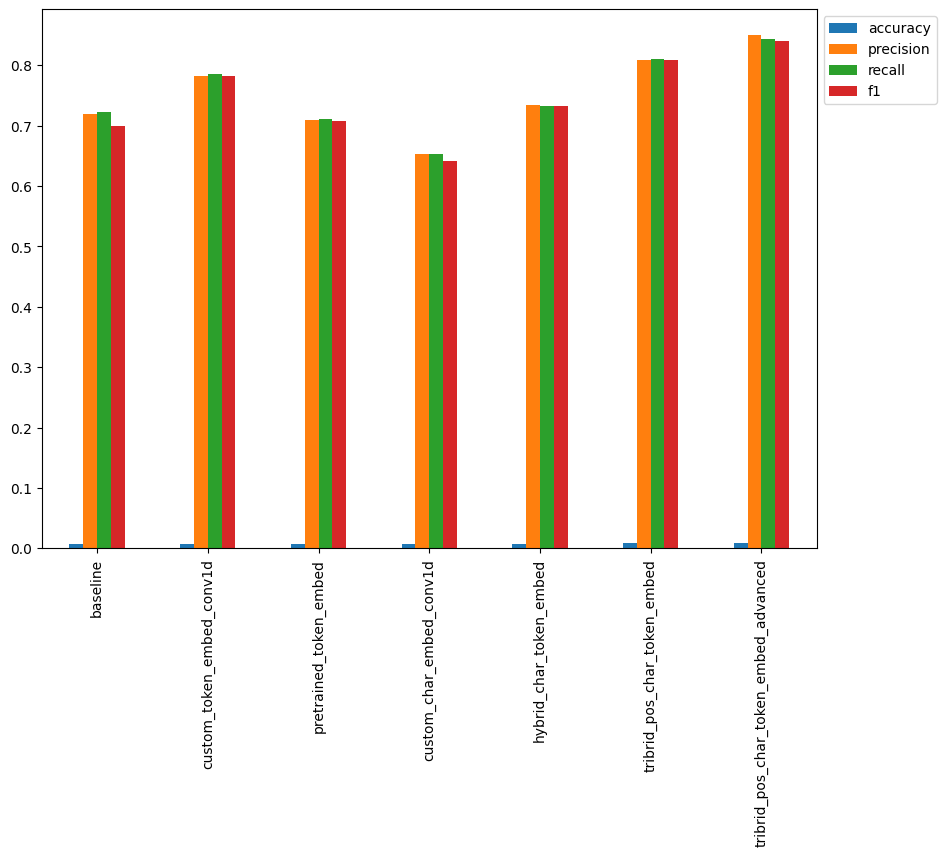

In [137]:
# Visualize all model results

# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

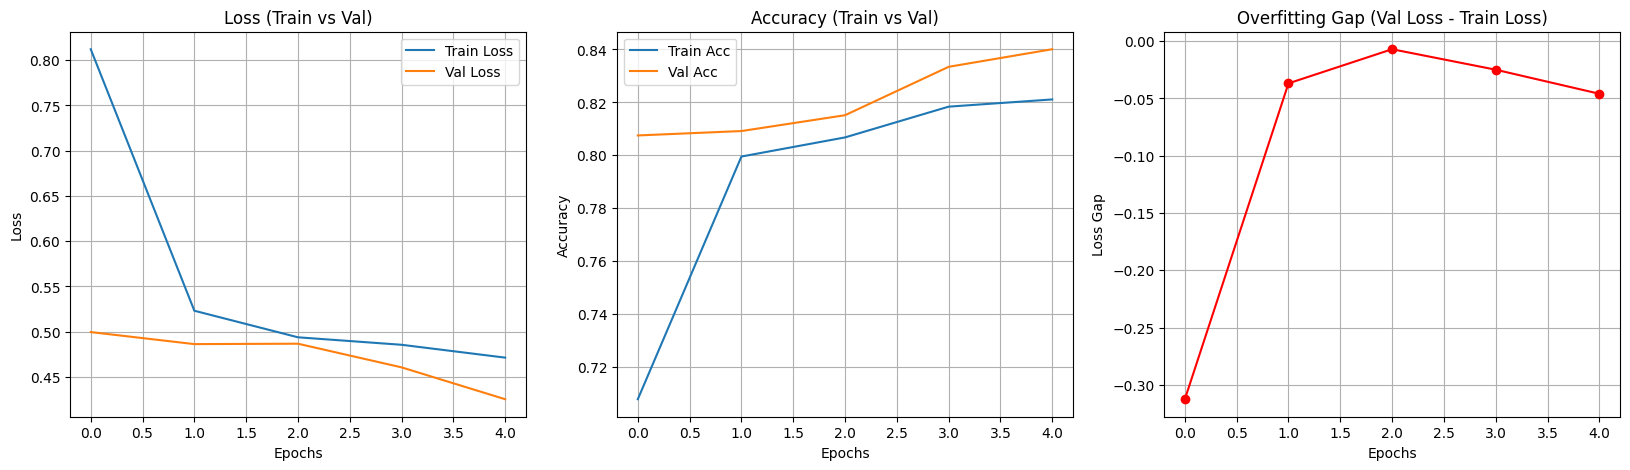

In [127]:
def plot_training_curves(history):
    # 1. Loss & Accuracy từ history
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    # 2. Tính Overfitting Gap
    gap = [v - t for v, t in zip(val_loss, train_loss)]

    # 3. Vẽ
    fig, axs = plt.subplots(1, 3, figsize=(20,5))

    # Loss
    axs[0].plot(train_loss, label="Train Loss")
    axs[0].plot(val_loss, label="Val Loss")
    axs[0].set_title("Loss (Train vs Val)")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    # Accuracy
    axs[1].plot(train_acc, label="Train Acc")
    axs[1].plot(val_acc, label="Val Acc")
    axs[1].set_title("Accuracy (Train vs Val)")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True)

    # Overfitting Gap
    axs[2].plot(gap, marker="o", color="red")
    axs[2].set_title("Overfitting Gap (Val Loss - Train Loss)")
    axs[2].set_xlabel("Epochs")
    axs[2].set_ylabel("Loss Gap")
    axs[2].grid(True)

    plt.show()
plot_training_curves(history_model_6)


## Test final model on test dataset

In [134]:
test_abstract_pred_probs = model_6.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 1s 726ms/step


array([[3.68641049e-01, 8.08220636e-03, 4.57585294e-04, 6.22593462e-01,
        2.25701937e-04],
       [5.91499149e-04, 4.81869902e-05, 9.97335732e-01, 1.62846845e-04,
        1.86176295e-03],
       [1.21422723e-01, 3.16988933e-03, 7.84356952e-01, 8.61684978e-02,
        4.88192216e-03],
       [3.31322812e-02, 4.21443619e-02, 7.84775972e-01, 5.59328543e-03,
        1.34354040e-01],
       [3.38757504e-03, 1.32259224e-02, 6.98837399e-01, 1.86730502e-03,
        2.82681763e-01],
       [2.06756592e-03, 3.58330309e-02, 8.18788588e-01, 1.25117402e-03,
        1.42059669e-01],
       [1.35861672e-04, 2.66720742e-01, 5.70462197e-02, 2.95426998e-05,
        6.76067650e-01],
       [7.26338694e-05, 2.30129272e-01, 1.14604235e-01, 1.74398869e-04,
        6.55019522e-01]], dtype=float32)

In [135]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
    print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
